## IMPORTS

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans, Birch, DBSCAN
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from pyclustertend import hopkins

## DATA LOADING

In [37]:
data = pd.read_csv('../data/cleaned/data_final.csv', )
data = data.drop(columns="url")
data.head()


,price,zone,neighborhood,built_area,usable_area,bedrooms,bathrooms,floor,exterior,elevator,garage,storage_room,balcony,new,condition,year,agency,consumption_label,emissions_label,description
0,440000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",76.0,70.000000,2,2,3.0,exterior,True,True,True,True,False,Buen estado,2025.0,ORDUNTE Inmobiliaria,A,A,"GASTOS DE GESTIoN de 1,5 por ciento + IVA a ca..."
1,442000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",82.0,67.104025,2,2,1.0,exterior,True,True,False,True,True,Nuevo,2025.0,LOIOLA GESTIoN INMOBILIARIA,A,A,La nueva promocion de Loiola se compone de 42 ...
2,381000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",58.0,44.045770,1,1,4.0,exterior,True,True,False,True,True,Nuevo,2025.0,LOIOLA GESTIoN INMOBILIARIA,A,A,La nueva promocion de Loiola se compone de 42 ...
3,575000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",104.0,88.240759,3,2,1.0,exterior,True,True,False,True,True,Nuevo,2025.0,LOIOLA GESTIoN INMOBILIARIA,A,A,La nueva promocion de Loiola se compone de 42 ...
4,306000.0,deusto,"La Ribera-Ibarrekolanda, Bilbao",62.0,47.888812,1,1,1.0,exterior,True,True,False,False,True,Nuevo,2025.0,Loiola,A,A,"60 viviendas de obra nueva de 1, 2 y 3 habitac..."


In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1229 entries, 0 to 1228
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              1229 non-null   float64
 1   zone               1229 non-null   object 
 2   neighborhood       1229 non-null   object 
 3   built_area         1229 non-null   float64
 4   usable_area        1229 non-null   float64
 5   bedrooms           1229 non-null   int64  
 6   bathrooms          1229 non-null   int64  
 7   floor              1229 non-null   float64
 8   exterior           1229 non-null   object 
 9   elevator           1229 non-null   bool   
 10  garage             1229 non-null   bool   
 11  storage_room       1229 non-null   bool   
 12  balcony            1229 non-null   bool   
 13  new                1229 non-null   bool   
 14  condition          1229 non-null   object 
 15  year               1229 non-null   float64
 16  agency             1229 

## FEATURE SELECTION

In [39]:
# DEFINE COLUMNS AND DATA TYPE

columnascategory = ["zone","neighborhood","exterior","condition","agency","consumption_label","emissions_label"]
data[columnascategory] = data[columnascategory].astype('category')
numerical_cols = ['price', 'built_area', 'usable_area', 'bedrooms', 'bathrooms', 'floor', 'year']
data[numerical_cols] = data[numerical_cols].astype('int')
categorical_cols = list(data.select_dtypes(include=['category']).columns)
boolean_cols = list(data.select_dtypes(include=['bool']).columns)


A = data[categorical_cols + numerical_cols + boolean_cols]

# PREPROCESING: OneHot + Passthrough
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('bool', 'passthrough', boolean_cols)
    ]
)

A_preprocessed = preprocessor.fit_transform(A)

ohe_cols = preprocessor.named_transformers_['cat'] \
        .get_feature_names_out(categorical_cols)

feature_names = numerical_cols + list(ohe_cols) + boolean_cols

# MAKE CLUSTERING TO OBTAIN LABELS
kmeans = KMeans(n_clusters=5, random_state=123)
clusters = kmeans.fit_predict(A_preprocessed)

# FEATURE SELECTION POR MUTUAL INFORMATION
if hasattr(A_preprocessed, "toarray"):
    A_dense = A_preprocessed.toarray()
else:
    A_dense = A_preprocessed

scores = mutual_info_classif(A_dense, clusters, random_state=123)

# CREATE RANKING OF FEATURES
ranking = pd.DataFrame({
    "feature": feature_names,
    "importance": scores
}).sort_values(by="importance", ascending=False)

#SPLIT FEATURES BASED ON A THRESHOLD
threshold = ranking["importance"].mean()
selected_features = ranking[ranking["importance"] > threshold]
removed_features = ranking[ranking["importance"] <= threshold]

# RESULT
print(" MOST IMPORTANT FEATURES ")
print(selected_features)
# THE MOST RELEVANT FEATURES ARE THE NUMERICAL ONES
print(" LESS IMPORTANT FEATURES ")
print(removed_features)
ranking.head()

 MOST IMPORTANT FEATURES 
                           feature  importance
0                            price    1.273963
1                       built_area    0.527204
2                      usable_area    0.489703
4                        bathrooms    0.365650
3                         bedrooms    0.219441
..                             ...         ...
366            consumption_label_A    0.018044
10                zone_casco-viejo    0.018002
116          agency_Carolina Marin    0.017761
341     agency_carlos buerba arena    0.017761
188  agency_INMOBILIARIA BASAGOITI    0.017627

[94 rows x 2 columns]
 LESS IMPORTANT FEATURES 
                                     feature  importance
185                            agency_INMOAS    0.017410
308  agency_Quorum Promociones de Obra Nueva    0.017220
148                    agency_Erreka Garrido    0.016931
60           neighborhood_Solokoetxe, Bilbao    0.016911
184                    agency_INFINITY HOMES    0.016837
..                 

,feature,importance
0,price,1.273963
1,built_area,0.527204
2,usable_area,0.489703
4,bathrooms,0.365650
3,bedrooms,0.219441


## KMEANS

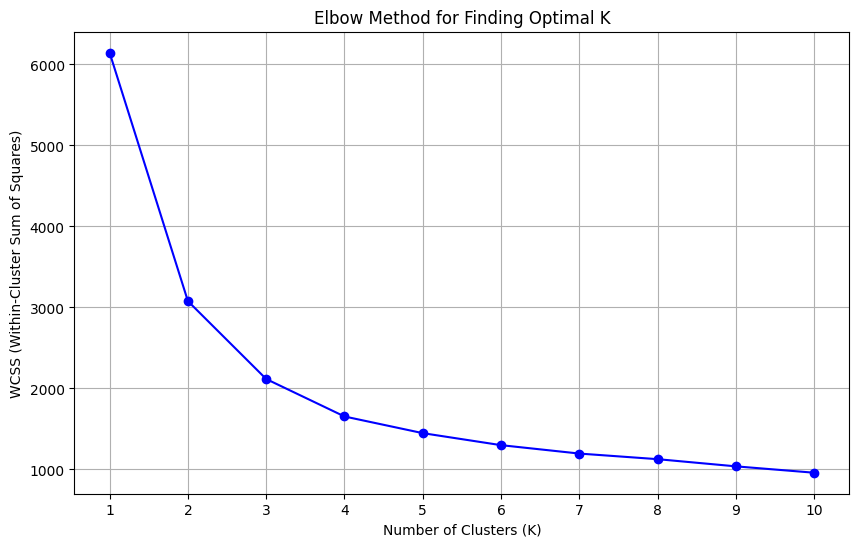

K=2: Silhouette Score = 0.5712
K=3: Silhouette Score = 0.4116
K=4: Silhouette Score = 0.4212
K=5: Silhouette Score = 0.3776
K=6: Silhouette Score = 0.3625
K=7: Silhouette Score = 0.3629
K=8: Silhouette Score = 0.3661
K=9: Silhouette Score = 0.3535
K=10: Silhouette Score = 0.3584
--- Silhouette Analysis Result ---
Kmeans Silhouette Score = 0.41155510072631113
Kmeans Calinski-Harabasz: 1167.0011067462078
Log-Likelihood of the best K Means model: -2600849.70
AIC of the best K Means model: 2146.23
BIC of the best K Means model: 2222.94


In [40]:
features = ['price', 'built_area', 'bedrooms', 'bathrooms', 'usable_area']
X = data[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

wcss = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Elbow Method Visualization (saves the plot)
plt.figure(figsize=(10, 6))

plt.plot(K_range, wcss, marker='o', linestyle='-', color='blue')
plt.title('Elbow Method for Finding Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.xticks(K_range)
plt.grid(True)
plt.show()  

# Define K range for silhouette analysis
silhouette_scores = {}
K_range = range(2, 11) 

for k in K_range:
    # Train K-Means
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=100)
    cluster_labels = kmeans.fit_predict(X_scaled)

    # Calculate Silhouette Score
    score = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores[k] = score
    print(f"K={k}: Silhouette Score = {score:.4f}")

# Find K with the highest score
K_optimal_silhouette = max(silhouette_scores, key=silhouette_scores.get)
best_score = silhouette_scores[K_optimal_silhouette]

print("--- Silhouette Analysis Result ---")

K_OPTIMAL = 3 # The optimal k according to elbow is 3 and according to silhouette is 2; 3 is chosen to maintain consistency with the elbow

kmeans_final = KMeans(n_clusters=K_OPTIMAL, init='k-means++', random_state=42, n_init=10)
y_kmeans = kmeans_final.fit_predict(X_scaled) 
silhouette_avg = silhouette_score(X_scaled, y_kmeans) # Calculate the overall Silhouette Score

print(f"Kmeans Silhouette Score = {silhouette_avg}") 

# --- Hopkins Statistic Calculation ---
X_scaled
n_samples = X_scaled.shape[0]

puntuacion = calinski_harabasz_score(X_scaled, y_kmeans)

print(f"Kmeans Calinski-Harabasz: {puntuacion}")

#implement the log of likelihood for the best model
log_likelihood = kmeans_final.score(X_scaled) * X_scaled.shape[0]  # Total log-likelihood
print(f"Log-Likelihood of the best K Means model: {log_likelihood:.2f}")
#implement aic and bic for the best model
aic_best = kmeans_final.inertia_ + 2 * K_OPTIMAL * X_scaled.shape[1]
bic_best = kmeans_final.inertia_ + np.log(n_samples) * K_OPTIMAL * X_scaled.shape[1]
print(f"AIC of the best K Means model: {aic_best:.2f}")
print(f"BIC of the best K Means model: {bic_best:.2f}")


## GAUSSIAN MIXTURE

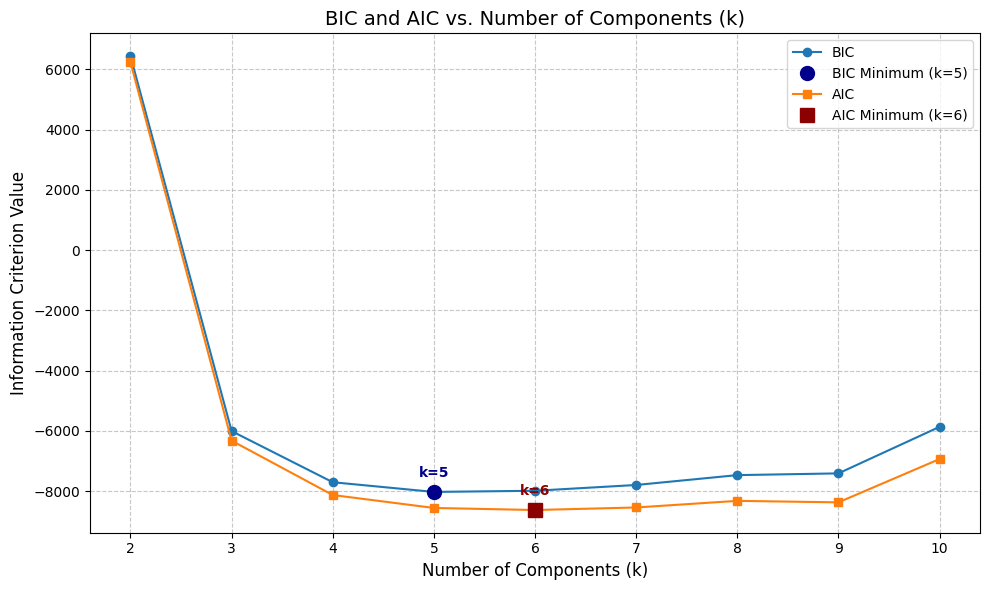

In [41]:
# Use Bayesian Information Criterion (BIC) and Akaike Information Criterion (AIC)
n_components = np.arange(2, 11)
models = [GaussianMixture(n, covariance_type='full', random_state=42).fit(X_scaled) for n in n_components]

# Calculate BIC and AIC
bic = [m.bic(X_scaled) for m in models]
aic = [m.aic(X_scaled) for m in models]

# Find the minimum points
min_bic_index = np.argmin(bic)
min_aic_index = np.argmin(aic)
optimal_k_bic = n_components[min_bic_index]
optimal_k_aic = n_components[min_aic_index]

# --- Plot Generation ---
plt.figure(figsize=(10, 6))

# Plot BIC
plt.plot(n_components, bic, label='BIC', marker='o', color='tab:blue')
# Mark the BIC minimum point
plt.plot(optimal_k_bic, bic[min_bic_index], 'o', color='darkblue', markersize=10, label=f'BIC Minimum (k={optimal_k_bic})')
plt.text(optimal_k_bic, bic[min_bic_index] + 500, f'k={optimal_k_bic}', ha='center', color='darkblue', fontweight='bold')

# Plot AIC
plt.plot(n_components, aic, label='AIC', marker='s', color='tab:orange')
# Mark the AIC minimum point
plt.plot(optimal_k_aic, aic[min_aic_index], 's', color='darkred', markersize=10, label=f'AIC Minimum (k={optimal_k_aic})')
plt.text(optimal_k_aic, aic[min_aic_index] + 500, f'k={optimal_k_aic}', ha='center', color='darkred', fontweight='bold')

# Titles and Labels
plt.title('BIC and AIC vs. Number of Components (k)', fontsize=14)
plt.xlabel('Number of Components (k)', fontsize=12)
plt.ylabel('Information Criterion Value', fontsize=12)
plt.xticks(n_components) # Ensures only tested k values are shown
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='upper right')
plt.tight_layout() # Automatically adjusts subplot parameters

# Show the plot
plt.show()



#print("--- Resultados de BIC y AIC para GMM ---")
#print("BIC;", bic)
#print("AIC;", aic)



In [42]:
lowest_bic = np.inf
best_gmm = None
optimal_k = 5
optimal_cv_type = ''
cv_types = ['spherical', 'tied', 'full','diag'] 

# Using the improved features with a k different from 4, I surpassed it.

print("--- Grid Search: k and Covariance Type ---")
for cv_type in cv_types:
    for n_comp in n_components: 
        # If the model does not converge, it might raise an error. Using try/except for robustness.
        try:
            gmm_model = GaussianMixture(n_components=n_comp, covariance_type=cv_type, random_state=42)
            gmm_model.fit(X_scaled)
            current_bic = gmm_model.bic(X_scaled)
            # Check if this is the best BIC model so far
            if current_bic < lowest_bic:
                lowest_bic = current_bic
                optimal_k = n_comp
                optimal_cv_type = cv_type
                best_gmm = gmm_model
        except Exception as e:
            # Ignore models that do not converge
            print(f"Warning: Model k={n_comp}, cv='{cv_type}' failed.")
            continue

print(f"\nBest BIC Combination Found: k={optimal_k}, Covariance='{optimal_cv_type}'")
print(f"Minimum BIC: {lowest_bic:.2f}")

# --- Re-apply GMM with the BEST BIC Model and Evaluate Silhouette ---
if best_gmm is not None:
    cluster_gmm_final = best_gmm.predict(X_scaled)
    silhouette_avg_final = silhouette_score(X_scaled, cluster_gmm_final,)
    
    print(f"\n--- FINAL Model Results (k={optimal_k}, {optimal_cv_type}) ---")
    print(f"Gaussian Mixture Silhouette Score: {silhouette_avg_final:.4f}")
    puntuacion = calinski_harabasz_score(X_scaled, cluster_gmm_final)
    print(f"Gaussian Mixture Calinski-Harabasz: {puntuacion}")
    
else:
    print(" Could not find a convergent GMM model. Check data cleaning.")

# implement the log of likelihood for the best model
if best_gmm is not None:
    log_likelihood = best_gmm.score(X_scaled) * X_scaled.shape[0]  # Total log-likelihood
    print(f"Log-Likelihood of the best GMM model: {log_likelihood:.2f}")
    
# implement aic and bic for the best model
    aic_best = best_gmm.aic(X_scaled)
    bic_best = best_gmm.bic(X_scaled)
    print(f"AIC of the best GMM model: {aic_best:.2f}")
    print(f"BIC of the best GMM model: {bic_best:.2f}")

--- Grid Search: k and Covariance Type ---

Best BIC Combination Found: k=5, Covariance='full'
Minimum BIC: -8023.23

--- FINAL Model Results (k=5, full) ---
Gaussian Mixture Silhouette Score: 0.3715
Gaussian Mixture Calinski-Harabasz: 521.9502243749367
Log-Likelihood of the best GMM model: 4381.54
AIC of the best GMM model: -8555.08
BIC of the best GMM model: -8023.23


## BIRCH MODE

In [51]:
# --- 1. Grid Search Configuration ---
# Threshold: The radius of the sub-cluster. 

threshold_values = [0.1, 0.2, 0.05, 0.075, 0.25, 0.25]

# Branching Factor: How many sub-nodes each branch can have. 
#   - 50 is standard, tested 20 and 100 to see if it affects tree structure.
branching_values = [5, 10, 15, 20, 50, 100]

# n_clusters: The final refinement step.
n_clusters_values = [  4, 5, 6, 7, 8, 9, 10]

results = []
best_score = -1
best_params = {}
best_labels = None

print("Starting hyperparameter search for BIRCH...")

count = 0
total_iters = len(threshold_values) * len(branching_values) * len(n_clusters_values)

for t in threshold_values:
    for b in branching_values:
        for k in n_clusters_values:
            try:
                # Train BIRCH
                # n_clusters=k forces a final agglomeration step to reach k groups
                birch = Birch(threshold=t, branching_factor=b, n_clusters=k)
                labels = birch.fit_predict(X_scaled)
                
                # Validate that it hasn't generated a single cluster by mistake
                unique_labels = np.unique(labels)
                if len(unique_labels) < 2:
                    continue
                
                # Calculate metrics
                sil = silhouette_score(X_scaled, labels)
                ch = calinski_harabasz_score(X_scaled, labels)
                
                # Analyze distribution (to detect giant clusters)
                counts = pd.Series(labels).value_counts()
                max_ratio = counts.max() / len(labels) # % of the largest cluster
                
                results.append({
                    'threshold': t,
                    'branching': b,
                    'n_clusters': k,
                    'silhouette': sil,
                    'calinski': ch,
                    'max_cluster_ratio': max_ratio
                })
                
                # Save the best (Maximizing Silhouette)
                if sil > best_score and max_ratio < 0.8: # Avoid unbalanced clusters
                    best_score = sil
                    best_model = birch
                    best_params = {'threshold': t, 'branching': b, 'n_clusters': k}
                    best_labels = labels
                    print(f"  ->  New best: k={k}, thr={t}, Silhouette={sil:.4f} (Max Cluster: {max_ratio:.1%})")
                    
            except Exception as e:
                # Sometimes BIRCH fails if the threshold is too low for the data volume
                continue

# --- 2. Search Results ---

print("\n" + "="*40)
print(f"🏆 BEST BIRCH CONFIGURATION")
print("="*40)
print(f"Threshold (Radius): {best_params['threshold']}")
print(f"Branching Factor: {best_params['branching']}")
print(f"Number of Clusters (k): {best_params['n_clusters']}")
print(f"Silhouette: {best_score:.4f}")

# --- 3. Point Distribution Analysis (As requested) ---

if best_labels is not None:
    print("\nDetailed Analysis of Winning Clusters:")
    
    # Create summary DataFrame
    df_dist = pd.Series(best_labels).value_counts().reset_index()
    df_dist.columns = ['Cluster_Label', 'Point_Count']
    
    # Calculate percentage
    total_pts = len(X_scaled)
    df_dist['Percentage'] = (df_dist['Point_Count'] / total_pts) * 100
    df_dist = df_dist.sort_values(by='Cluster_Label')
    
    print(df_dist.to_string(index=False))
    
    # Balance alert
    max_pct = df_dist['Percentage'].max()
    if max_pct > 80:
        print(f"\n NOTE: The dominant cluster has {max_pct:.1f}% of the data.")
        print("If k=2, this might be normal (background vs anomaly), but check it.")
    elif max_pct < 60 and best_params['n_clusters'] == 2:
        print("\n Excellent balance: Groups are well distributed.")

# --- 4. Top 5 Configurations ---
print("\nTop 5 Configurations tested:")
df_results = pd.DataFrame(results)
print(df_results.sort_values(by='silhouette', ascending=False).head(5))


silhouette_avg_final = silhouette_score(X_scaled, best_labels)
print(f"Birch Silhouette Score: {silhouette_avg_final:.4f}")
puntuacion = calinski_harabasz_score(X_scaled, best_labels)
print(f"Birch Calinski-Harabasz: {puntuacion}")
#Log-Likelihood of the best model is not applicable for BIRCH
print("Log-Likelihood of the best BIRCH model: Not Applicable")
#NOT POSSIBLE TO IMPLEMENT AIC AND BIC FOR BIRCH
print("AIC of the best BIRCH model: Not Applicable")
print("BIC of the best BIRCH model: Not Applicable")


Starting hyperparameter search for BIRCH...
  ->  New best: k=4, thr=0.1, Silhouette=0.3689 (Max Cluster: 77.2%)
  ->  New best: k=5, thr=0.1, Silhouette=0.3690 (Max Cluster: 39.7%)
  ->  New best: k=6, thr=0.1, Silhouette=0.3766 (Max Cluster: 39.7%)
  ->  New best: k=7, thr=0.1, Silhouette=0.3774 (Max Cluster: 39.7%)
  ->  New best: k=4, thr=0.1, Silhouette=0.4038 (Max Cluster: 44.3%)
  ->  New best: k=5, thr=0.1, Silhouette=0.4066 (Max Cluster: 44.3%)
  ->  New best: k=4, thr=0.1, Silhouette=0.4086 (Max Cluster: 50.4%)
  ->  New best: k=4, thr=0.1, Silhouette=0.4117 (Max Cluster: 41.7%)
  ->  New best: k=5, thr=0.1, Silhouette=0.4120 (Max Cluster: 41.7%)
  ->  New best: k=5, thr=0.2, Silhouette=0.4121 (Max Cluster: 43.4%)
  ->  New best: k=5, thr=0.05, Silhouette=0.4156 (Max Cluster: 45.8%)

🏆 BEST BIRCH CONFIGURATION
Threshold (Radius): 0.05
Branching Factor: 15
Number of Clusters (k): 5
Silhouette: 0.4156

Detailed Analysis of Winning Clusters:
 Cluster_Label  Point_Count  Percenta

## DB SCAN 

In [45]:
# --- Search Configuration ---

# 1. RANGE ADJUSTMENT:
# If you previously had a giant cluster, we need smaller 'eps'.
eps_values = np.arange(0.05, 2.0, 0.05)
# 2. INCREASE MIN_SAMPLES:
# Increasing this breaks weak bridges between clusters.
min_samples_values = np.arange(5, 31, 1)

best_score = -1
best_params = {'eps': None, 'min_samples': None}
best_labels = None
results = []

print(" Starting optimized search to avoid 'Mega-Clusters'...")

for eps in eps_values:
    for ms in min_samples_values:
        
        # Run DBSCAN
        db = DBSCAN(eps=eps, min_samples=ms)
        labels = db.fit_predict(X_scaled)
        
        # Basic statistics
        unique_labels = set(labels)
        n_clusters = len(unique_labels) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        total_samples = len(labels)
        noise_ratio = n_noise / total_samples
        
        # --- NEW FILTER: LARGEST CLUSTER SIZE ---
        # Calculate what percentage of data the largest cluster holds
        if n_clusters > 0:
            counts = pd.Series(labels).value_counts()
            if -1 in counts: counts = counts.drop(-1) # Ignore noise for this calculation
            largest_cluster_ratio = counts.max() / total_samples
        else:
            largest_cluster_ratio = 1.0 # If everything is noise or a single group

        #The largest cluster CANNOT have more than 70% of the data
        
        if (2 <= n_clusters <= 50) and (noise_ratio < 0.50) and (largest_cluster_ratio < 0.7):
            
            core_mask = labels != -1
            if np.sum(core_mask) > len(unique_labels): 
                sil_score = silhouette_score(X_scaled[core_mask], labels[core_mask])
                
                results.append({
                    'eps': eps, 
                    'min_samples': ms, 
                    'n_clusters': n_clusters, 
                    'noise_ratio': noise_ratio, 
                    'largest_cluster_ratio': largest_cluster_ratio,
                    'silhouette': sil_score
                })
                
                # Save the best
                if sil_score > best_score:
                    best_score = sil_score
                    best_params = {'eps': eps, 'min_samples': ms}
                    best_labels = labels
                    print(f"  ->  Candidate: eps={eps:.2f}, ms={ms} | Clusters={n_clusters} | Max_Cluster={largest_cluster_ratio:.2%} | Silhouette={sil_score:.4f}")

# --- Results ---
if best_params['eps'] is not None:
    print("\n" + "="*40)
    print(f"BEST BALANCED CONFIGURATION")
    print("="*40)
    print(f"Epsilon: {best_params['eps']:.2f}")
    print(f"Min Samples: {best_params['min_samples']}")
    print(f"Silhouette: {best_score:.4f}")
    best_models = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
    
    # Show size distribution
    final_counts = pd.Series(best_labels).value_counts().sort_index()
    print("\nDistribution by cluster (Label: Count):")
    print(final_counts.to_string())
    
    # Top 5 summary table
    df_res = pd.DataFrame(results)
    print("\nTop 5 configurations:")
    print(df_res.sort_values(by='silhouette', ascending=False).head(5)[['eps', 'min_samples', 'n_clusters', 'largest_cluster_ratio', 'silhouette']])

else:
    print("\nNo valid configuration found yet.")
    print("Try: 1) Slightly increasing the allowed noise limit, or 2) Check if variables need a transformation (Log/PowerTransform) before scaling.")


conteos = pd.Series(best_labels).value_counts().sort_index()

print("Point distribution by Cluster:")
print(conteos)


core_mask =  best_labels!= -1 

if np.sum(core_mask) > len(unique_labels): 
    sil_score = silhouette_score(X_scaled[core_mask], best_labels[core_mask])

print(f"DB SCAN Silhouette Score(SIN OUTLIERS): {sil_score:.4f}")
puntuacion = calinski_harabasz_score(X_scaled[core_mask], best_labels[core_mask])
print(f"DB SCAN Calinski-Harabasz (SIN OUTLIERS): {puntuacion}")

#not possible to implement the log of likelihood for the best model

# not possible to implement the aix and bic for the best model
                                                                        

 Starting optimized search to avoid 'Mega-Clusters'...
  ->  Candidate: eps=0.15, ms=5 | Clusters=19 | Max_Cluster=14.24% | Silhouette=0.3500
  ->  Candidate: eps=0.15, ms=6 | Clusters=17 | Max_Cluster=13.67% | Silhouette=0.4103
  ->  Candidate: eps=0.15, ms=7 | Clusters=14 | Max_Cluster=13.02% | Silhouette=0.4976
  ->  Candidate: eps=0.30, ms=29 | Clusters=5 | Max_Cluster=15.87% | Silhouette=0.4992
  ->  Candidate: eps=0.30, ms=30 | Clusters=5 | Max_Cluster=15.87% | Silhouette=0.5021

BEST BALANCED CONFIGURATION
Epsilon: 0.30
Min Samples: 30
Silhouette: 0.5021

Distribution by cluster (Label: Count):
-1    579
 0     89
 1     46
 2    195
 3    142
 4    178

Top 5 configurations:
     eps  min_samples  n_clusters  largest_cluster_ratio  silhouette
53   0.3           30           5               0.158666    0.502092
259  0.7           28           2               0.400325    0.500231
261  0.7           30           2               0.400325    0.500231
260  0.7           29           

DEALING WITH OUTLIERS


In [46]:
mask_core = best_labels != -1
X_core = X_scaled[mask_core]   # Points already assigned
y_core = best_labels[mask_core]
X_noise = X_scaled[~mask_core] # To predict


def calcular_k_optimo_explicado(X_train, X_query, k_min=3, k_max=15):
    """
    Calcula el K óptimo basándose en cuándo la distancia a los vecinos
    empieza a crecer demasiado (criterio del codo).
    """
    print(f"--- KINDER NEIGHBOR ANALYSIS (KNN) FOR REASSIGNMENT ---")
   
    # We use NearestNeighbors only to measure distances (not yet classified)
    nbrs = NearestNeighbors(n_neighbors=k_max, algorithm='auto').fit(X_train)
    
    mean_distances = []
    best_k = k_min
    prev_slope = 0
    elbow_found = False
    
    print(f"|  K  | Average Distance | Acceleration (Shift) | Decision")
    print("|-----|-----------------|----------------------|---------")

    for k in range(k_min, k_max + 1):
        distances, _ = nbrs.kneighbors(X_query, n_neighbors=k)
        avg_dist = np.mean(distances)
        mean_distances.append(avg_dist)
        
        slope = 0
        decision = ""
        
        if k > k_min:
            slope = avg_dist - mean_distances[-2]
            
            # CRITERION: If the current slope is much greater than the previous one,
            # it means we are jumping to distant neighbors (another cluster or distant noise).
            # We use a factor of 1.5 as the "sharp jump" threshold.
            if not elbow_found and slope > prev_slope * 1.5 and prev_slope > 0:
                decision = "ELBOW: Distance increases dramatically. We stop here."
                best_k = k - 1 # We'll stick with the one before the jump
                elbow_found = True
            elif not elbow_found:
                decision = "Stable. Searching better option"
                best_k = k # We'll stick with the one before the jump
        else:
            decision = "Start Point"
            
        prev_slope = slope if slope > 0 else 1e-6
        
# We print the analysis row by row
    print(f"| {k:^3} | {avg_dist:.4f}          | {slope:.4f}               | {decision}")
        
        

    print(f">>> CONCLUSION: k ={best_k}")
    print(f"Reason: It is the equilibrium point where we have the most \nlocal information before the neighbors start to be too far away (risk of contamination).")
    
    return best_k

if len(X_noise) > 0:
    # Forcing to find at least 5 neighbors to ensure a solid vote
    k_optimo = calcular_k_optimo_explicado(X_core, X_noise, k_min=5, k_max=15)
else:
    k_optimo = 5  # Default value if no noise

# 2. Train KNN using the automatically calculated k_optimum
print(f"Training KNeighborsClassifier with n_neighbors={k_optimo}...")
knn = KNeighborsClassifier(n_neighbors=k_optimo)
knn.fit(X_core, y_core)

# 3. Predict and Create Final Labels
if len(X_noise) > 0:
    noise_pred = knn.predict(X_noise)
    final_labels = best_labels.copy()
    final_labels[~mask_core] = noise_pred
    print("Labels for noise points have been predicted and assigned.")
else:
    final_labels = best_labels.copy()
    




--- KINDER NEIGHBOR ANALYSIS (KNN) FOR REASSIGNMENT ---
|  K  | Average Distance | Acceleration (Shift) | Decision
|-----|-----------------|----------------------|---------
| 15  | 1.8126          | 0.0049               | 
>>> CONCLUSION: k =5
Reason: It is the equilibrium point where we have the most 
local information before the neighbors start to be too far away (risk of contamination).
Training KNeighborsClassifier with n_neighbors=5...
Labels for noise points have been predicted and assigned.


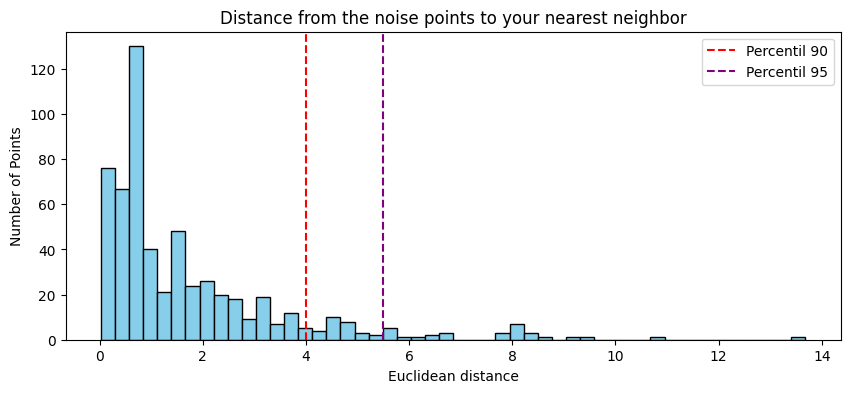

Distance statistics:
count    579.000000
mean       1.709666
std        1.867541
min        0.024454
25%        0.585417
50%        0.921069
75%        2.245701
max       13.683108
dtype: float64
Applying distance cut-off: 5.50
Final Cluster Count (with isolated real outliers):
-1     29
 0    110
 1     92
 2    615
 3    192
 4    191
Name: count, dtype: int64
Final Silhouette Score after KNN reassignment: 0.1815
Final Calinski-Harabasz Score after KNN reassignment: 414.6392
Log-Likelihood of the best DBSCAN model: Not Applicable
AIC of the best DBSCAN model: Not Applicable
BIC of the best DBSCAN model: Not Applicable


In [ ]:
# 1. We reclaim distances and neighbors
# distance: how far away is the neighbor
# indices: who is the neighbor
distances, indices = knn.kneighbors(X_noise)

# We keep the distance to the nearest neighbor (column 0)
dist_to_neighbor = distances[:, 0]

# CRITICAL STEP: VIEW THE HISTOGRAM TO DECIDE ON THE CUT-OFF POINT 
plt.figure(figsize=(10, 4))
plt.hist(dist_to_neighbor, bins=50, color='skyblue', edgecolor='black')
plt.axvline(np.percentile(dist_to_neighbor, 90), color='r', linestyle='--', label='Percentil 90')
plt.axvline(np.percentile(dist_to_neighbor, 95), color='purple', linestyle='--', label='Percentil 95')
plt.title('Distance from the noise points to your nearest neighbor')
plt.xlabel('Euclidean distance')
plt.ylabel('Number of Points')
plt.legend()
plt.show()

print("Distance statistics:")
print(pd.Series(dist_to_neighbor).describe())

# 2. APPLY THE FILTER (RIGHT OF ADMISSION) 
# Define your limit here based on the graph above.
# From what I see in your PCA, the far points are VERY far away.
# A safe value is usually the 95th percentile (discard the furthest 5%).
limite_distancia = np.percentile(dist_to_neighbor, 95) 

print(f"Applying distance cut-off: {limite_distancia:.2f}")

# Predict again
noise_pred_filtered = knn.predict(X_noise)

# Where the distance is greater than the limit, we force back to -1 (Real Noise)
noise_pred_filtered[dist_to_neighbor > limite_distancia] = -1

# Update end labels
final_labels_refined = best_labels.copy()
final_labels_refined[~mask_core] = noise_pred_filtered



# Final count
print("Final Cluster Count (with isolated real outliers):")
print(pd.Series(final_labels_refined).value_counts().sort_index())

#Silhouette Score of the final assignment
silhouette_final = silhouette_score(X_scaled, final_labels_refined)
print(f"Final Silhouette Score after final DBSCAN + KNN reassignment: {silhouette_final:.4f}")
#CALINSKI HARABASZ SCORE
puntuacion = calinski_harabasz_score(X_scaled, final_labels_refined)
print(f"Final Calinski-Harabasz Score after final DBSCAN + KNN reassignment: {puntuacion:.4f}")


print(f"Log-Likelihood of the best DBSCAN model: Not Applicable")
print(f"AIC of the best DBSCAN model: Not Applicable")
print(f"BIC of the best DBSCAN model: Not Applicable")

## RESUMEN FINAL

MASTER TABLE: Numeric Profile (Means)
               Count       price  built_area  usable_area  bedrooms  bathrooms  floor     year
Cluster_Final                                                                                 
0                548   516251.91      115.17       102.01      3.11       2.00   3.85  1974.04
1                 34   937878.35      286.38       251.76      6.53       2.38   3.21  1940.12
2                128   844228.57      191.90       175.04      4.52       3.00   3.45  1953.55
3                488   263139.34       71.68        64.72      2.25       1.00   3.61  1951.90
4                 31  1127709.65      276.06       250.13      5.42       4.00   3.90  1954.19


🎨 DISTRIBUTION OF CATEGORICAL AND BOOLEAN VARIABLES BY CLUSTER (True/False)

🔹 Variable: ELEVATOR
elevator       False  True 
Cluster_Final              
0                1.5   98.5
1                8.8   91.2
2                7.0   93.0
3                0.2   99.8
4                6.5   93.5
-

C:\Users\gonzalo.iglesias\AppData\Local\Temp\ipykernel_10144\582028482.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster_Final', y='price', data=df_analysis, palette='tab10')


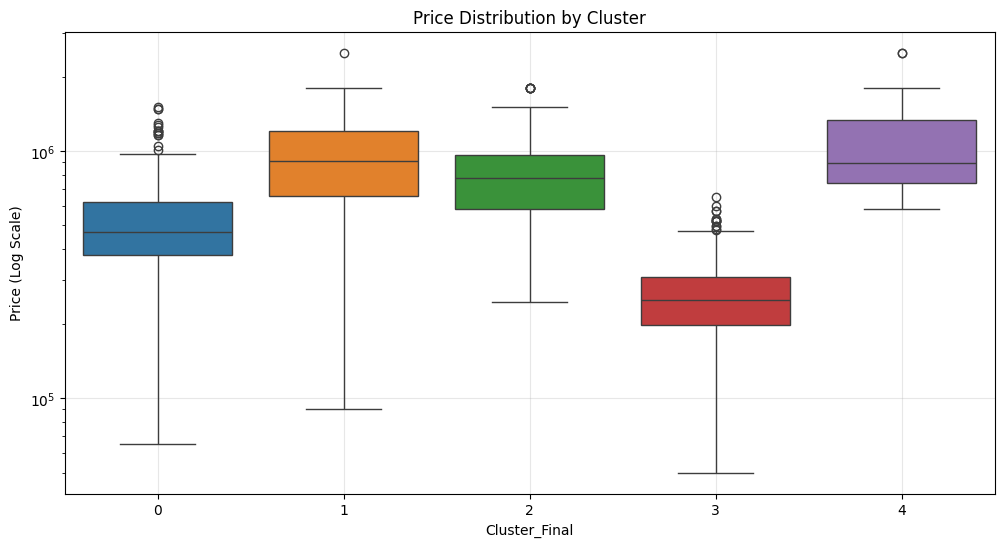

In [50]:
# 1. Preparation
df_analysis = data.copy()
df_analysis['Cluster_Final'] = cluster_gmm_final

# --- PART A: Numeric Variables ONLY (Means) ---
print("MASTER TABLE: Numeric Profile (Means)")
print("=========================================")

# Filter numeric columns excluding booleans
numerical_only = [col for col in numerical_cols if col not in boolean_cols]

# 1. Group numeric variables (Mean + Count)
summary_num = df_analysis.groupby('Cluster_Final')[numerical_only].mean()

# 2. Add the count
conteo = df_analysis['Cluster_Final'].value_counts().sort_index()
summary_num.insert(0, 'Count', conteo) 

# Round and show the table of ONLY NUMERIC variables
print(summary_num.round(2).to_string())


# --- PART B: Categorical and BOOLEAN Variables (% Distribution) ---
print("\n\n🎨 DISTRIBUTION OF CATEGORICAL AND BOOLEAN VARIABLES BY CLUSTER (True/False)")
print("="*60)

# Combine boolean and categorical variables for frequency analysis (pd.crosstab)
all_cols_to_crosstab = boolean_cols + categorical_cols

# Iterate through each column
for col in all_cols_to_crosstab:
    print(f"\n🔹 Variable: {col.upper()}")
    
    # Cross-tabulation: Rows=Cluster, Columns=Categories (or True/False for booleans)
    cross_tab = pd.crosstab(
        df_analysis['Cluster_Final'], 
        df_analysis[col], 
        normalize='index' # Normalize by row (cluster)
    ) * 100
    
    print(cross_tab.round(1).to_string())
    print("-" * 60)

# --- PART C: Price Visualization ---
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster_Final', y='price', data=df_analysis, palette='tab10')
plt.title('Price Distribution by Cluster')
plt.yscale('log') 
plt.ylabel('Price (Log Scale)')
plt.grid(True, alpha=0.3)
plt.show()